## Solve pendulum with Deep Deterministic Policy Gradient

Solve the [pendulum environment](https://gym.openai.com/envs/Pendulum-v0/) using the Deep Deterministic Policy Gradient (DDPG) method. 

The pendulum task has a continuous action space, meaning simple policy gradient and Q-learning methods does not work.
Instead we can use an actor-critic approach known as the Deep Deterministic Policy Gradient method (DDPG). 
DDPG consists of a critic, $Q$, trained with squared loss:

$$
\begin{align}
y &= r + \gamma Q(s',\mu(s';\theta^{\mu'});\theta^{Q'}) \\
L(\theta) &= \mathbb{E}_{s,a,r,s'}[(y - Q(s,a;\theta))^2] \ ,
\end{align}
$$

and an actor, $\mu$, with a continuous output trained with the deterministic policy gradient:

$$
\nabla_{\theta^\mu} \mu \approx \mathbb{E}[\nabla_a Q(s,\mu(s);\theta^Q) \nabla_{\theta^\mu} \mu(s;\theta^\mu)] \ .
$$

Notice how a target actor and critic are used to compute the target value, $y$. 
The target network parameters are delayed copies of $\theta^Q$ and $\theta^\mu$, respectively, updated with "soft" target updates:

$$
\begin{align}
\theta^{Q'} &= \tau \theta^Q + (1-\tau) \theta^{Q'} \\
\theta^{\mu'} &= \tau \theta^\mu + (1-\tau) \theta^{\mu'} \ ,
\end{align}
$$

with $\tau \ll 1$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.nn import relu, tanh
import gym
from collections import deque

In [2]:
env = gym.make('Pendulum-v0')

[2017-12-20 16:10:17,561] Making new env: Pendulum-v0


In [3]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, size):
        self.size = size
        self.memory = deque(maxlen=size)
    
    def add(self, s, a, r, s1, d):
        """Add experience to memory."""
        self.memory.append((s, a, r, s1, d))
    
    def sample(self, batch_size, replace=False):
        """Sample batch of experiences from memory with replacement."""
        idx = np.random.choice(len(self.memory), batch_size, replace=replace)
        batch = np.array([self.memory[i] for i in idx]).T
        ss, aa, rr, ss1, dd = (list(batch[i]) for i in range(5))
        return ss, aa, rr, ss1, dd
    
    @property
    def count(self):
        return len(self.memory)

In [4]:
class Actor(object):
    """Policy network with target network"""
    
    def __init__(self, n_s, n_h1, n_h2, n_a, learning_rate, tau, scope='actor'):
        # setup main net
        with tf.variable_scope(scope):
            self.states, self.out = self._create_net(n_s, n_h1, n_h2, n_a)
            self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
            self.action_grads = tf.placeholder(tf.float32, [None, n_a])
            self.grads = tf.gradients(self.out, self.trainables, -self.action_grads)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.update = self.optimizer.apply_gradients(zip(self.grads, self.trainables))
        # setup target net
        target_scope = '%s_target' % scope
        with tf.variable_scope(target_scope):
            self.target_states, self.target_out = self._create_net(n_s, n_h1, n_h2, n_a)
            self.target_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=target_scope) 
            self.copy_target = self._assign_target_trainables(tau=1.0)
            self.update_target = self._assign_target_trainables(tau=tau)
    
    def _create_net(self, n_s, n_h1, n_h2, n_a):
        states = tf.placeholder(tf.float32, [None, n_s], name='states')
        net = tf.layers.dense(inputs=states, units=n_h1, activation=relu, name='hidden1')
        net = tf.layers.dense(inputs=net, units=n_h2, activation=relu, name='hidden2')
        out = tf.layers.dense(inputs=net, units=n_a, activation=tanh, name='out')
        out = tf.multiply(out, 2) # scale output
        return states, out
    
    def _assign_target_trainables(self, tau):
        # ops for copying trainables from the main net to the target net with rate tau
        return [t.assign((1-tau) * t.value() + tau * self.trainables[i].value()) \
                for i, t in enumerate(self.target_trainables)]

In [5]:
class Critic(object):
    """Q-network with target network"""
    
    def __init__(self, n_s, n_h1, n_h2, n_a, learning_rate, tau, scope='critic'):
        # setup main net
        with tf.variable_scope(scope):         
            self.states, self.actions, self.out = self._create_net(n_s, n_h1, n_h2, n_a)
            self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
            self.targets = tf.placeholder(tf.float32, [None, 1], name='targets')
            self.loss = tf.reduce_sum(tf.square(self.targets - self.out))
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.update = self.optimizer.minimize(self.loss)
            self.action_grads = tf.gradients(self.out, self.actions)
        # setup target net
        target_scope = '%s_target' % scope
        with tf.variable_scope(target_scope):
            self.target_states, self.target_actions, self.target_out = self._create_net(n_s, n_h1, n_h2, n_a)
            self.target_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=target_scope) 
            self.copy_target = self._assign_target_trainables(tau=1.0)
            self.update_target = self._assign_target_trainables(tau=tau)
    
    def _create_net(self, n_s, n_h1, n_h2, n_a):
        states = tf.placeholder(tf.float32, [None, n_s], name='states')
        actions = tf.placeholder(tf.float32, [None, n_a], name='actions')
        net = tf.layers.dense(states, units=n_h1, activation=relu)
        net = tf.concat([net, actions], 1) # input actions at second hidden layer
        net = tf.layers.dense(net, units=n_h2, activation=relu)
        out = tf.layers.dense(inputs=net, units=1, activation=None, name='out')
        return states, actions, out
    
    def _assign_target_trainables(self, tau):
        # ops for copying trainables from the main net to the target net with rate tau
        return [t.assign((1-tau) * t.value() + tau * self.trainables[i].value()) \
                for i, t in enumerate(self.target_trainables)]

In [6]:
num_episodes = 100
episode_limit = env.spec.timestep_limit
batch_size = 64

replay_memory_size = 100000

actor_learning_rate = 0.00005
critic_learning_rate = 0.0005
tau = 0.001 # target network update rate

gamma = 0.99 # discount rate

print_freq = 10

# net size
n_s = env.observation_space.shape[0]
n_a = env.action_space.shape[0]
n_h1 = 200
n_h2 = 100

# create networks
tf.reset_default_graph()
actor = Actor(n_s, n_h1, n_h2, n_a, actor_learning_rate, tau)
critic = Critic(n_s, n_h1, n_h2, n_a, critic_learning_rate, tau)

saver = tf.train.Saver()
save_path = 'tmp/pendulum_ddpg'

# initialize replay memory
replay_memory = ReplayMemory(replay_memory_size)
print('prefill memory')
s = env.reset()
while replay_memory.count < replay_memory.size:
    a = env.action_space.sample()
    s1, r, d, _ = env.step(a)
    replay_memory.add(s, a, r, s1, d)
    s = s1 if not d else env.reset()

# training loop
try:
    with tf.Session() as sess:
        print('start training')
        sess.run(tf.global_variables_initializer())
        sess.run([actor.copy_target, critic.copy_target])
        rewards = []
        for i in range(num_episodes):
            s = env.reset()
            reward = 0
            for j in range(episode_limit):
                # take step in environment
                a = sess.run(actor.out, feed_dict={actor.states: [s]}) + np.random.normal() * 0.1 # action w. exploration noise
                s1, r, d, _ = env.step(a[0])
                replay_memory.add(s, a, r, s1, d)
                s = s1
                reward += r
                # train
                if replay_memory.count >= batch_size:
                    # sample batch
                    ss, aa, rr, ss1, dd = replay_memory.sample(batch_size)
                    # compute targets
                    target_a = sess.run(actor.target_out, feed_dict={actor.target_states: ss1})
                    target_q = sess.run(critic.target_out, feed_dict={critic.target_states: ss1, critic.target_actions: target_a})
                    targets = [rr[k] + gamma * target_q[k] * (not dd[k]) for k in range(batch_size)]
                    # update critic
                    sess.run(critic.update, feed_dict={critic.states: ss, critic.actions: aa, critic.targets: targets})
                    # comput action gradients
                    a_out = sess.run(actor.out, feed_dict={actor.states: ss})
                    action_grads = sess.run(critic.action_grads, feed_dict={critic.states: ss, critic.actions: a_out})
                    # update actor
                    sess.run(actor.update, feed_dict={actor.states: ss, actor.action_grads: action_grads[0]})
                    # update target nets
                    sess.run([actor.update_target, critic.update_target])
                if d: break
            rewards.append(reward)
            if (i+1) % print_freq == 0:
                print('%4d mean training reward: %8.2f' % (i+1, np.mean(rewards[-print_freq:])))
        print('done')
        # save model
        if not os.path.exists(save_path): os.makedirs(save_path)
        latest = saver.save(sess, os.path.join(save_path, 'model'))
except KeyboardInterrupt:
    pass

prefill memory
start training
  10 mean training reward: -1521.85
  20 mean training reward: -1298.92
  30 mean training reward: -1035.15
  40 mean training reward: -1136.08
  50 mean training reward: -1044.69
  60 mean training reward:  -267.09
  70 mean training reward:  -543.32
  80 mean training reward:  -176.70
  90 mean training reward:  -587.26
 100 mean training reward:  -182.86
done


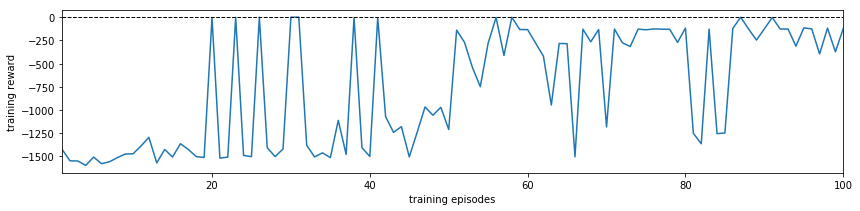

In [7]:
plt.figure(figsize=(14,3))
plt.plot(range(1, len(rewards)+1), rewards)
plt.axhline(0, color='k', linewidth=1, linestyle='--')
plt.xlim([1, num_episodes])
plt.xlabel('training episodes'); plt.ylabel('training reward')
plt.show()

In [8]:
# review solution
with tf.Session() as sess:
    saver.restore(sess, latest)
    s = env.reset()
    for _ in range(env.spec.timestep_limit):
        env.render()
        a = sess.run(actor.out, feed_dict={actor.states: [s]})
        #a += np.random.normal() * 0.5 # noise
        s, r, done, _ = env.step(a[0])
    env.render(close=True)

INFO:tensorflow:Restoring parameters from tmp/pendulum_ddpg/model


[2017-12-20 16:14:07,893] Restoring parameters from tmp/pendulum_ddpg/model
